In [1]:
!pip install -q scikit-lego
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

--2024-08-05 06:22:35--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: '/tmp/rose-pine-dawn.mplstyle'

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.04s   

2024-08-05 06:22:36 (1.09 MB/s) - '/tmp/rose-pine-dawn.mplstyle' saved [40905/40905]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, log_loss
import warnings

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

In [3]:
plt.style.use('ggplot')

# Get Data
Okay so let´s first load our data and get a general overview about it.

In [4]:
train_competition = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
train_original = pd.read_csv('/kaggle/input/secondary-mushroom-dataset-data-set/MushroomDataset/secondary_data.csv', sep=';')
train = pd.concat([train_competition, train_original], ignore_index=True)
cols = train.columns.to_list()
cols.remove("class")
train = train.drop_duplicates(subset=cols, keep='first')
train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


# Descriptive Statistics

## Train

In [6]:
print(train.shape)
train.describe().style.background_gradient('Blues')

(3177860, 21)


,cap-diameter,stem-height,stem-width
count,3177856.000000,3177860.000000,3177860.000000
mean,6.318132,6.353103,11.173426
std,4.670758,2.714103,8.138104
min,0.030000,0.000000,0.000000
25%,3.320000,4.670000,4.980000
50%,5.750000,5.880000,9.660000
75%,8.250000,7.410000,15.650000
max,80.670000,88.720000,103.910000


## Test

In [7]:
print(test.shape)
test.describe().style.background_gradient('Blues')

(2077964, 20)


,cap-diameter,stem-height,stem-width
count,2077957.000000,2077963.000000,2077964.000000
mean,6.306192,6.346509,11.148374
std,4.685462,2.698978,8.100181
min,0.000000,0.000000,0.000000
25%,3.310000,4.670000,4.970000
50%,5.740000,5.880000,9.640000
75%,8.230000,7.410000,15.620000
max,607.000000,57.290000,102.910000


# Missing Values

In [8]:
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Train Missing %', 'Test Missing %']
for column in train.columns:
    data_type = str(train[column].dtype)
    non_null_count_train= np.round(100-train[column].count()/train.shape[0]*100,1)
    if column!='class':
        non_null_count_test = np.round(100-test[column].count()/test.shape[0]*100,1)
    else:
        non_null_count_test="NA"
    table.add_row([column, data_type, non_null_count_train,non_null_count_test])
print(table)

+----------------------+-----------+-----------------+----------------+
|       Feature        | Data Type | Train Missing % | Test Missing % |
+----------------------+-----------+-----------------+----------------+
|        class         |   object  |       0.0       |       NA       |
|     cap-diameter     |  float64  |       0.0       |      0.0       |
|      cap-shape       |   object  |       0.0       |      0.0       |
|     cap-surface      |   object  |       21.6      |      21.5      |
|      cap-color       |   object  |       0.0       |      0.0       |
| does-bruise-or-bleed |   object  |       0.0       |      0.0       |
|   gill-attachment    |   object  |       16.8      |      16.8      |
|     gill-spacing     |   object  |       40.4      |      40.4      |
|      gill-color      |   object  |       0.0       |      0.0       |
|     stem-height      |  float64  |       0.0       |      0.0       |
|      stem-width      |  float64  |       0.0       |      0.0 

A lot of missing values are in both datasets. According to several disucssions, they hold substantil information like [here](https://www.kaggle.com/competitions/playground-series-s4e8/discussion/523474). 

In [9]:
# Source: https://www.kaggle.com/code/stealthtechnologies/lb-0-98513-multiple-lightgbm-models
def cleaning(df):
    
    threshold = 100
    
    cat_feats = ["cap-shape","cap-surface","cap-color","does-bruise-or-bleed","gill-attachment",
                "gill-spacing","gill-color","stem-root","stem-surface","stem-color","veil-type",
                "veil-color","has-ring","ring-type","spore-print-color","spore-print-color",
                "habitat","season"]
    
    for feat in cat_feats:
        df[feat] = df[feat].fillna('missing')
        df.loc[df[feat].value_counts(dropna=False)[df[feat]].values < threshold, feat] = "noise"
        df[feat] = df[feat].astype('category')
    
    return df

train  = cleaning(train)
test  = cleaning(test)

In [10]:
train.isnull().sum()

class                   0
cap-diameter            4
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

In [11]:
print('Number of missing values in test set')
test.isnull().sum()

Number of missing values in test set


cap-diameter            7
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             1
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-type               0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

2 columns still contain a few missing values. Those are numeric ones, so we will impute them with the median value of the column. 

In [12]:
# Separate numerical and categorical columns
num_features = train._get_numeric_data().columns
cat_features = train.drop(num_features, axis=1).columns
cat_features = cat_features[cat_features != 'class']

In [13]:
# Inspired by: https://www.kaggle.com/code/krishnadaskv/pss4e8-mushrooms-base-model
# Numerical transformer and imputer for numerical data
numerical_transformer = SimpleImputer(strategy='median')
train[num_features] = numerical_transformer.fit_transform(train[num_features])
test[num_features] = numerical_transformer.transform(test[num_features])

# EDA
## Target Distribution

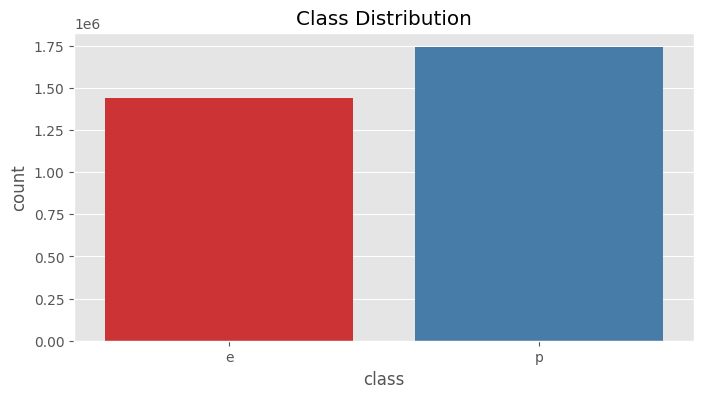

In [14]:
plt.figure(figsize=(8, 4))
sns.countplot(data=train, x='class', palette='Set1')
plt.title('Class Distribution')
plt.show();

We are good to go, target column is almost balanced.

## Numeric Feature Distribution

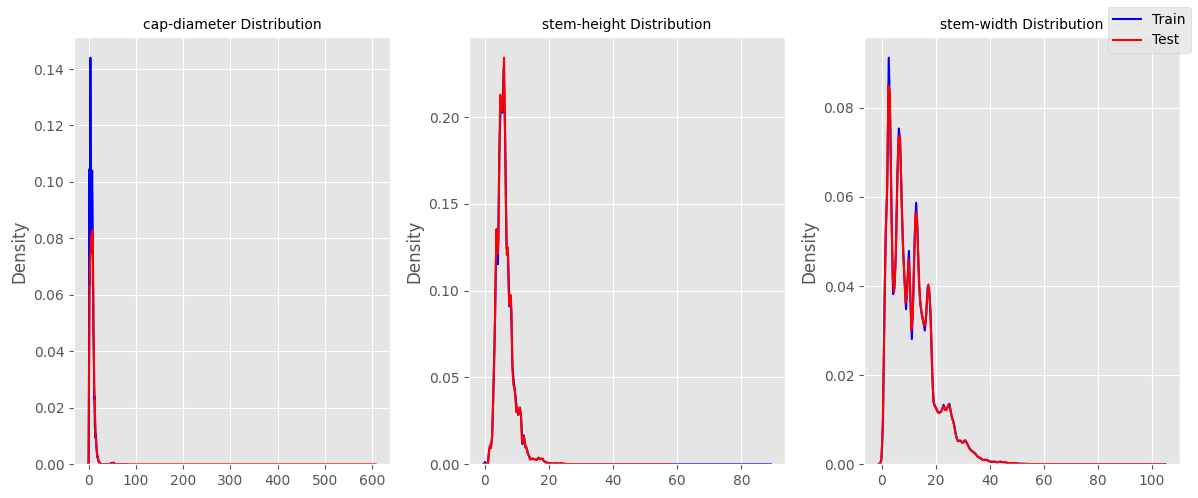

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax = ax.flatten()
for idx,column in enumerate(num_features):
    if column in train.columns:
        sns.kdeplot(data=train, x=column, ax=ax[idx], label='Train', color='blue')
    if column in test.columns:
        sns.kdeplot(data=test, x=column, ax=ax[idx], label='Test', color='red')
    
    ax[idx].set_title(f'{column} Distribution', size = 10)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
fig.legend(['Train', 'Test'])
plt.tight_layout()
plt.show();

All numerical features are very skewed. We could think about some transformation but we will skip it in this notebook. LightGBM can handle skewed data. I will skip visualization for categorical features due to the ordinal encoding I did above. 

# Modeling
I will train a base LightGBM model to predict the mushroom class. 

In [16]:
le = LabelEncoder()
train['class'] = le.fit_transform(train['class'])

In [17]:
X = train.drop(columns=['class'])
y = train['class']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')

X Train Shape: (2542288, 20)
X Test Shape: (635572, 20)


In [20]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc, True

In [21]:
params = {'objective':'binary',
          'n_estimators':100,
          'max_depth': 14,
          'reg_alpha': 3,
          'reg_lambda': 3,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'random_state': 1702,
          'verbose': 1
         }

In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [23]:
model = lgb.train(params,
                 num_boost_round=500,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 feval=mcc_metric
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1391306, number of negative: 1150982
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.540519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 2542288, number of used features: 20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.547265 -> initscore=0.189627
[LightGBM] [Info] Start training from score 0.189627


In [24]:
# Run prediction
y_pred = model.predict(X_test)

In [25]:
y_pred_round = np.round(y_pred)
y_pred_round

array([1., 1., 0., ..., 0., 1., 0.])

In [26]:
matthews_corrcoef(y_test, y_pred_round)

0.9820223467353567

In [27]:
accuracy_score(y_test, y_pred_round)

0.9910867690835972

In [28]:
print(classification_report(y_test, y_pred_round))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    287745
           1       0.99      0.99      0.99    347827

    accuracy                           0.99    635572
   macro avg       0.99      0.99      0.99    635572
weighted avg       0.99      0.99      0.99    635572



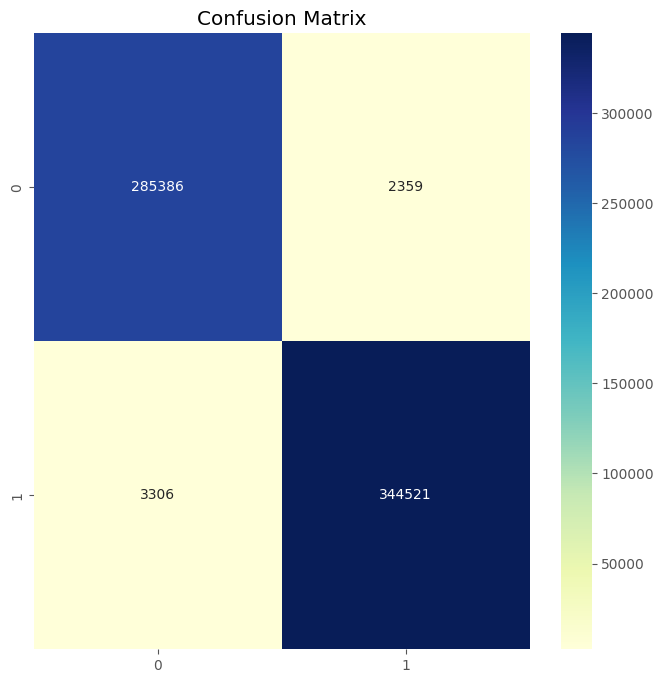

In [29]:
cm = confusion_matrix(y_test, y_pred_round)
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(8,8))
plt.title('Confusion Matrix')
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show();

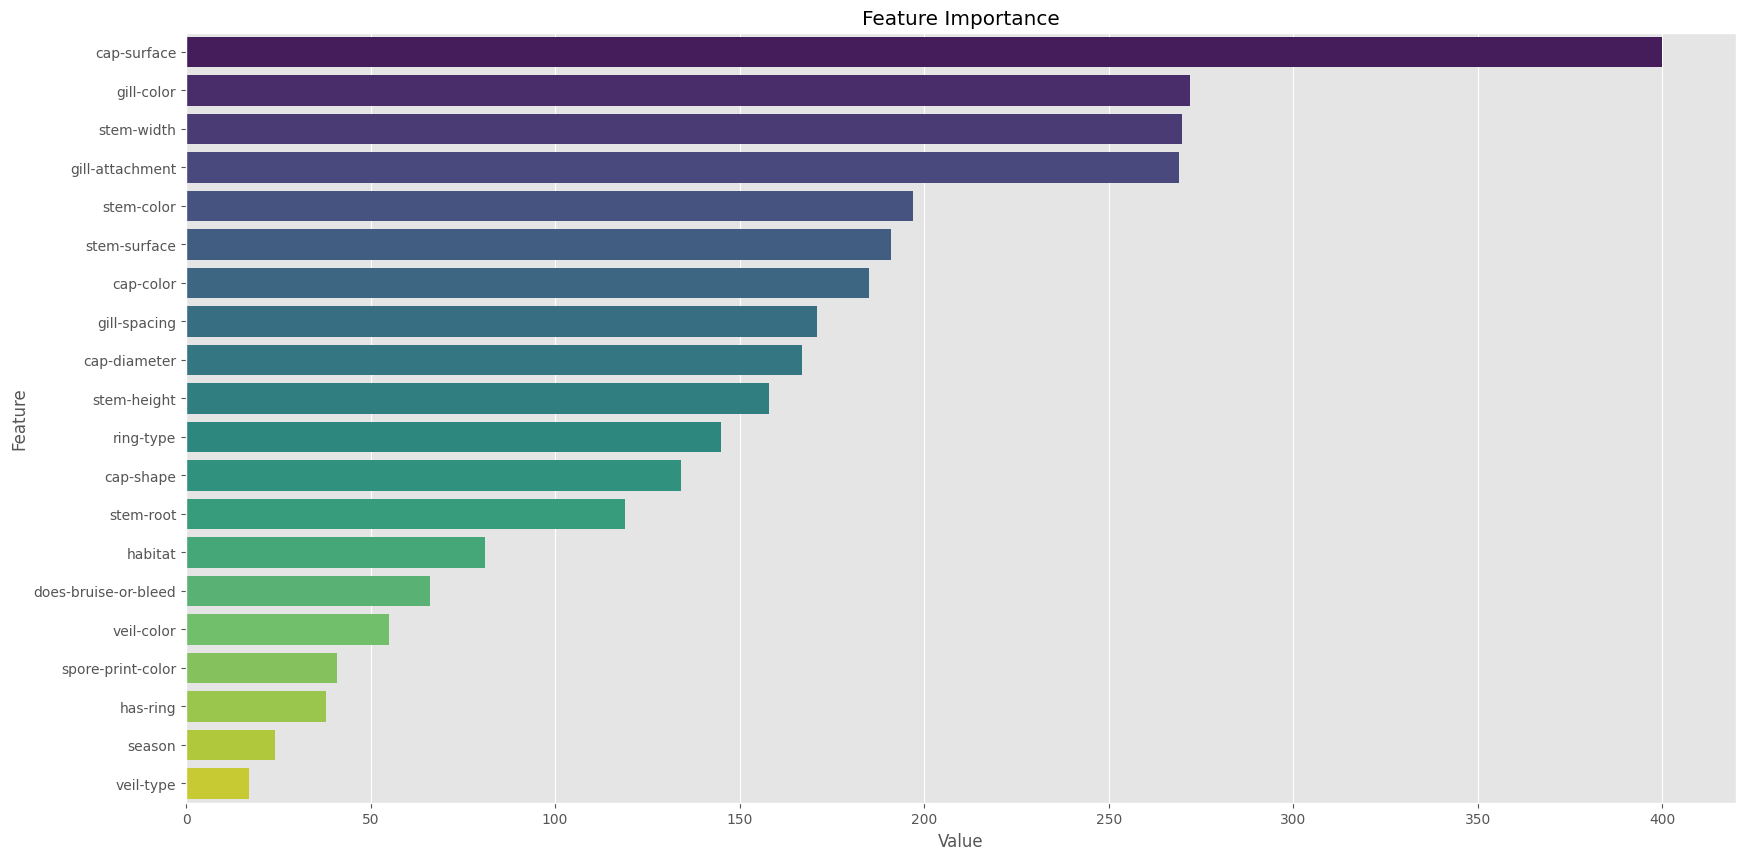

In [30]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
plt.title('Feature Importance')
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False), palette='viridis')
plt.show();

# Prediction and Submission

In [31]:
preds = model.predict(test)

In [32]:
test_pred_binary = (preds > 0.5).astype(int)
test_pred_binary

array([0, 1, 1, ..., 1, 0, 0])

In [33]:
test_classes = le.inverse_transform(test_pred_binary)
test_classes

array(['e', 'p', 'p', ..., 'p', 'e', 'e'], dtype=object)

In [34]:
test['class'] = test_classes
test[['class']].to_csv('submission.csv')